PCA code copied and adapted from: "Reducing dimensionality with principal component analysis with Python
Optimize the classification of a data set by applying PCA with Python" By Eda Kavlakoglu (https://developer.ibm.com/tutorials/awb-reducing-dimensionality-with-principal-component-analysis/)

In [70]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import os
import pickle
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [71]:
num_init_cond = 100

# Load data

train_file = 'data/Leslie/19.6_23.68_23.68/train.csv'
test_file = 'data/Leslie/19.6_23.68_23.68/test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

X_train = train_df[['x0', 'x1', 'x2']]
Y_train = train_df[['y0', 'y1', 'y2']]

last_100 = Y_train.tail(num_init_cond)
last_100.columns = ['x0', 'x1', 'x2']

all_dynamics = pd.concat([X_train, last_100], axis = 0, ignore_index=True)

print(all_dynamics)

X_test = test_df[['x0', 'x1', 'x2']]
Y_test = test_df[['y0', 'y1', 'y2']]

              x0          x1          x2
0     144.520948  198.379820   86.904899
1      50.813428  207.911919   28.015855
2     128.277017  202.091889   56.448103
3     111.067253   78.564222  185.403547
4      48.207928  117.953557  128.011347
...          ...         ...         ...
8095    7.251876   21.021378    3.553704
8096   30.030057    5.076313   14.714965
8097    7.252090   21.021040    3.553419
8098   30.030846    5.076463   14.714728
8099    7.251673   21.021592    3.553524

[8100 rows x 3 columns]


In [72]:
# Scale and center the data (mean zero, sd 1)

sc = StandardScaler()
all_dynamics_scaled = sc.fit_transform(all_dynamics)

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Y_train_scaled = sc.fit_transform(Y_train)
Y_test_scaled = sc.transform(Y_test)

all dynamics_scaled shape: (8100, 3)
Number of features: 3
X_train_scaled.T shape: (3, 8000)
cov_mat shape: (3, 3)
[[1.00012502 0.1667312  0.41621291]
 [0.1667312  1.00012502 0.39894236]
 [0.41621291 0.39894236 1.00012502]]


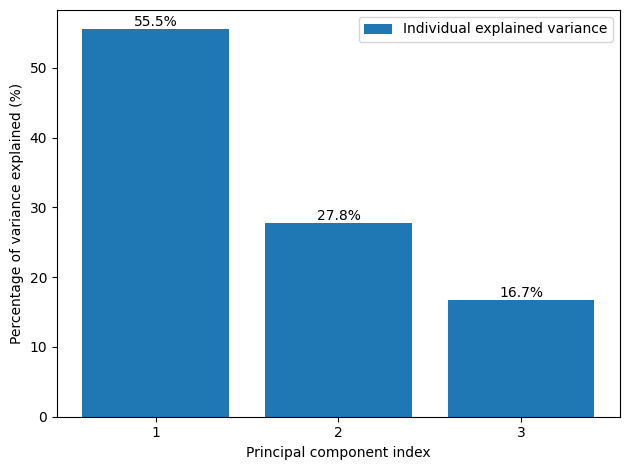

In [73]:
num_features = all_dynamics_scaled.shape[1]

print('all dynamics_scaled shape:', all_dynamics_scaled.shape)
print(f'Number of features: {num_features}')

print('X_train_scaled.T shape:', X_train_scaled.T.shape)

# covariance matrix, eigenvalues and eigenvectors
cov_mat = np.cov(X_train_scaled.T)

print('cov_mat shape:', cov_mat.shape)
print(cov_mat)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# sort eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

# explained variance percentages
exp_var = [(i / np.sum(eigen_vals)) * 100 for i in eigen_vals]

# plot
bar = plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
              label='Individual explained variance')

# add % labels on bars
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / (num_features - 1), bar.get_height(),
             f'{exp_var[i]:.1f}%', ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, len(exp_var) + 1)))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Scree Plot')

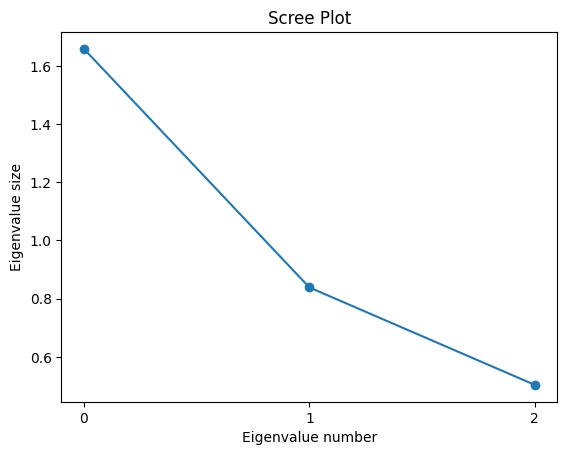

In [74]:
# generate scree plot
pca = PCA()
all_dynamics_scaled_transformed = pca.fit_transform(all_dynamics_scaled)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
x_ticks = list(range(0, len(explained_variance)))
plt.xticks(ticks=x_ticks)
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

In [75]:
pca_2 = PCA(n_components=2)
pca_2.fit(all_dynamics_scaled)

X_train_pca = pca_2.transform(X_train_scaled)
Y_train_pca = pca_2.transform(Y_train_scaled)

pca_df_X_train = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_train = pd.DataFrame(data=Y_train_pca, columns=['principal component 1', 'principal component 2'])

X_test_pca = pca_2.transform(X_test_scaled)
Y_test_pca = pca_2.transform(Y_test_scaled)

pca_df_X_test = pd.DataFrame(data=X_test_pca, columns=['principal component 1', 'principal component 2'])
pca_df_Y_test = pd.DataFrame(data=Y_test_pca, columns=['principal component 1', 'principal component 2'])

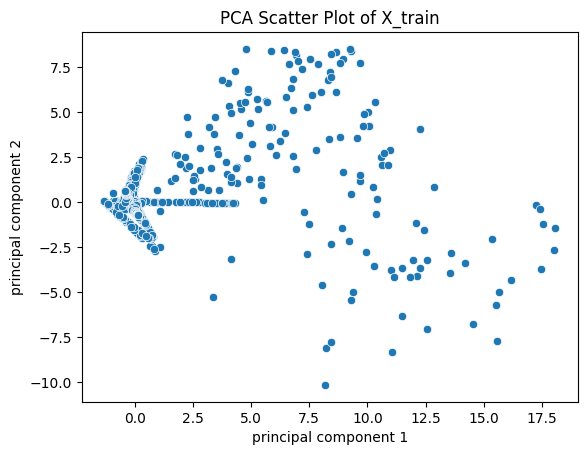

In [76]:
ax = sns.scatterplot(
    x=pca_df_X_train.iloc[:,0], 
    y=pca_df_X_train.iloc[:,1],
    data=pca_df_X_train,
    legend=True
)

# Add a title
ax.set_title("PCA Scatter Plot of X_train")

plt.show()

In [ ]:
# scale targets to lie in [-1, 1] x [-1, 1]
# Convert to numpy
y_train = pca_df_Y_train.values
y_test = pca_df_Y_test.values

# Get min/max from training set only
y_min = y_train.min(axis=0)
y_max = y_train.max(axis=0)

# Scale function
def scale_to_unit_interval(y, y_min, y_max):
    return 2 * (y - y_min) / (y_max - y_min + 1e-8) - 1

# Apply scaling
y_train_scaled = scale_to_unit_interval(y_train, y_min, y_max)
y_test_scaled = scale_to_unit_interval(y_test, y_min, y_max)

# Replace in your DataFrames
pca_df_Y_train = pd.DataFrame(y_train_scaled, columns=pca_df_Y_train.columns)
pca_df_Y_test = pd.DataFrame(y_test_scaled, columns=pca_df_Y_test.columns)

### Latent dynamics model training

#### Load data

In [93]:
X_train_tensor = torch.tensor(pca_df_X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(pca_df_Y_train.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

X_test_tensor = torch.tensor(pca_df_X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(pca_df_Y_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#### Define latent dynamics model

In [94]:
class LatentDynamics(nn.Module):
    def __init__(self, num_layers=3, hidden_shape=32, lower_shape=2):
        super(LatentDynamics, self).__init__()

        self.dynamics = nn.Sequential()
        for i in range(num_layers):
            if i == 0:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(lower_shape, hidden_shape))
            else:
                self.dynamics.add_module(f"linear_{i}", nn.Linear(hidden_shape, hidden_shape))
            self.dynamics.add_module(f"relu_{i}", nn.ReLU(True))
        self.dynamics.add_module(f"linear_{num_layers}", nn.Linear(hidden_shape, lower_shape))
      #  self.dynamics.add_module(f"tanh_{num_layers}", nn.Tanh())
    
    def forward(self, x):
        x = self.dynamics(x)
        return x

#### Define training class and train loop

In [95]:
class Training:
    def __init__(self, train_loader, test_loader, lr=0.001, model_dir='output/Leslie/models', log_dir='output/Leslie/logs', verbose=True):
        self.dynamics = LatentDynamics()
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.lr = lr

        self.model_dir = model_dir
        self.log_dir = log_dir

        self.verbose = bool(verbose)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device: ", self.device)

        self.dynamics.to(self.device)

        self.reset_losses()

        self.dynamics_criterion = nn.MSELoss(reduction='mean')

    def save_models(self, subfolder='', suffix=''):
        save_path = os.path.join(self.model_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)
        torch.save(self.dynamics, os.path.join(save_path, 'dynamics' + suffix + '.pt'))
    
    def load_models(self):
        self.dynamics = torch.load(os.path.join(self.model_dir, 'dynamics_.pt'))
    
    def save_logs(self, suffix=''):
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        with open(os.path.join(self.log_dir, 'train_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.train_losses, f)
        
        with open(os.path.join(self.log_dir, 'test_losses_' + suffix + '.pkl'), 'wb') as f:
            pickle.dump(self.test_losses, f)
    
    def reset_losses(self):
        self.train_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
        self.test_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_contrastive': [], 'loss_topo': [], 'loss_total': []}
    
    def forward(self, z_t, z_tau):
        # z_t = E(x_t)
        # z_tau = E(x_tau)

        # z_tau_pred = latent_dynamics(E(x_t))
        z_tau_pred = self.dynamics(z_t)

        return (z_tau, z_tau_pred)

    def dynamics_losses(self, forward_pass):
        z_tau, z_tau_pred = forward_pass
        loss_dyn = self.dynamics_criterion(z_tau_pred, z_tau)
        return loss_dyn
    
    def train(self, epochs=1000, patience=50):

        list_parameters = list(self.dynamics.parameters())
        optimizer = torch.optim.Adam(list_parameters, lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=patience)
        for epoch in tqdm(range(epochs)):

            epoch_train_loss = 0
            epoch_test_loss  = 0

            self.dynamics.train()

            num_batches = len(self.train_loader)
            for (x_t, x_tau) in self.train_loader:
                x_t = x_t.to(self.device)
                x_tau = x_tau.to(self.device)
                optimizer.zero_grad()

                # Forward pass (apply all models)
                forward_pass = self.forward(x_t, x_tau)
                # Compute losses
                loss_dyn = self.dynamics_losses(forward_pass)

                # Backward pass
                loss_dyn.backward()
                optimizer.step()

                epoch_train_loss += loss_dyn.item()

            epoch_train_loss /= num_batches

            self.train_losses['loss_total'].append(epoch_train_loss)

            self.dynamics.eval()
            with torch.no_grad():

                num_batches = len(self.test_loader)
                for (x_t, x_tau) in self.test_loader:
                    optimizer.zero_grad()

                    # Forward pass (apply all models)
                    forward_pass = self.forward(x_t, x_tau)
                    # Compute losses
                    loss_dyn = self.dynamics_losses(forward_pass)

                    epoch_test_loss += loss_dyn.item()

                epoch_test_loss /= num_batches

                self.test_losses['loss_total'].append(epoch_test_loss)

            scheduler.step(epoch_test_loss)
            
            if epoch >= patience:
                if np.mean(self.test_losses['loss_total'][-patience:]) > np.mean(self.test_losses['loss_total'][-patience-1:-1]):
                    if self.verbose:
                        print("Early stopping")
                    break
            
            if self.verbose:
                print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, epochs, epoch_train_loss, epoch_test_loss))

In [96]:
trainer = Training(train_loader=train_loader, test_loader=test_loader)
trainer.train()
trainer.save_logs()
trainer.reset_losses()
trainer.save_models()

Device:  cpu


  0%|          | 1/1000 [00:00<02:24,  6.90it/s]

Epoch [1/1000], Train Loss: 1.1881, Test Loss: 1.0100


  0%|          | 3/1000 [00:00<01:48,  9.17it/s]

Epoch [2/1000], Train Loss: 1.1927, Test Loss: 1.0099
Epoch [3/1000], Train Loss: 1.1809, Test Loss: 1.0098


  0%|          | 4/1000 [00:00<01:46,  9.38it/s]

Epoch [4/1000], Train Loss: 1.1767, Test Loss: 1.0100


  0%|          | 5/1000 [00:00<01:54,  8.72it/s]

Epoch [5/1000], Train Loss: 1.1838, Test Loss: 1.0100


  1%|          | 6/1000 [00:00<02:00,  8.23it/s]

Epoch [6/1000], Train Loss: 1.1832, Test Loss: 1.0102


  1%|          | 7/1000 [00:00<02:06,  7.84it/s]

Epoch [7/1000], Train Loss: 1.1888, Test Loss: 1.0105


  1%|          | 8/1000 [00:00<02:09,  7.64it/s]

Epoch [8/1000], Train Loss: 1.1909, Test Loss: 1.0106


  1%|          | 9/1000 [00:01<02:12,  7.45it/s]

Epoch [9/1000], Train Loss: 1.1859, Test Loss: 1.0105


  1%|          | 11/1000 [00:01<02:35,  6.35it/s]

Epoch [10/1000], Train Loss: 1.1822, Test Loss: 1.0106
Epoch [11/1000], Train Loss: 1.1806, Test Loss: 1.0104


  1%|▏         | 13/1000 [00:01<02:24,  6.85it/s]

Epoch [12/1000], Train Loss: 1.1955, Test Loss: 1.0102
Epoch [13/1000], Train Loss: 1.1854, Test Loss: 1.0107


  1%|▏         | 14/1000 [00:01<02:29,  6.61it/s]

Epoch [14/1000], Train Loss: 1.1817, Test Loss: 1.0107


  2%|▏         | 16/1000 [00:02<02:37,  6.26it/s]

Epoch [15/1000], Train Loss: 1.1872, Test Loss: 1.0104
Epoch [16/1000], Train Loss: 1.1792, Test Loss: 1.0104


  2%|▏         | 18/1000 [00:02<02:24,  6.79it/s]

Epoch [17/1000], Train Loss: 1.1812, Test Loss: 1.0104
Epoch [18/1000], Train Loss: 1.1853, Test Loss: 1.0101


  2%|▏         | 20/1000 [00:02<02:18,  7.07it/s]

Epoch [19/1000], Train Loss: 1.1819, Test Loss: 1.0107
Epoch [20/1000], Train Loss: 1.1856, Test Loss: 1.0102


  2%|▏         | 21/1000 [00:02<02:17,  7.15it/s]

Epoch [21/1000], Train Loss: 1.1751, Test Loss: 1.0102


  2%|▏         | 23/1000 [00:03<02:35,  6.26it/s]

Epoch [22/1000], Train Loss: 1.1835, Test Loss: 1.0101
Epoch [23/1000], Train Loss: 1.1859, Test Loss: 1.0101


  2%|▎         | 25/1000 [00:03<02:24,  6.75it/s]

Epoch [24/1000], Train Loss: 1.1957, Test Loss: 1.0105
Epoch [25/1000], Train Loss: 1.1870, Test Loss: 1.0103


  3%|▎         | 27/1000 [00:03<02:17,  7.09it/s]

Epoch [26/1000], Train Loss: 1.1885, Test Loss: 1.0103
Epoch [27/1000], Train Loss: 1.1880, Test Loss: 1.0103


  3%|▎         | 29/1000 [00:04<02:17,  7.08it/s]

Epoch [28/1000], Train Loss: 1.1846, Test Loss: 1.0101
Epoch [29/1000], Train Loss: 1.1802, Test Loss: 1.0099


  3%|▎         | 30/1000 [00:04<02:24,  6.73it/s]

Epoch [30/1000], Train Loss: 1.1888, Test Loss: 1.0100


  3%|▎         | 31/1000 [00:04<02:47,  5.77it/s]

Epoch [31/1000], Train Loss: 1.1831, Test Loss: 1.0102


  3%|▎         | 33/1000 [00:04<02:51,  5.64it/s]

Epoch [32/1000], Train Loss: 1.1788, Test Loss: 1.0101
Epoch [33/1000], Train Loss: 1.1842, Test Loss: 1.0099


  4%|▎         | 35/1000 [00:05<03:03,  5.26it/s]

Epoch [34/1000], Train Loss: 1.1776, Test Loss: 1.0103
Epoch [35/1000], Train Loss: 1.1815, Test Loss: 1.0103


  4%|▎         | 37/1000 [00:05<02:44,  5.85it/s]

Epoch [36/1000], Train Loss: 1.1755, Test Loss: 1.0100
Epoch [37/1000], Train Loss: 1.1839, Test Loss: 1.0097


  4%|▍         | 39/1000 [00:05<02:28,  6.46it/s]

Epoch [38/1000], Train Loss: 1.1778, Test Loss: 1.0099
Epoch [39/1000], Train Loss: 1.1895, Test Loss: 1.0101


  4%|▍         | 41/1000 [00:06<02:23,  6.66it/s]

Epoch [40/1000], Train Loss: 1.1820, Test Loss: 1.0106
Epoch [41/1000], Train Loss: 1.1854, Test Loss: 1.0099


  4%|▍         | 43/1000 [00:06<02:25,  6.58it/s]

Epoch [42/1000], Train Loss: 1.1854, Test Loss: 1.0099
Epoch [43/1000], Train Loss: 1.1870, Test Loss: 1.0100


  4%|▍         | 45/1000 [00:06<02:19,  6.85it/s]

Epoch [44/1000], Train Loss: 1.1843, Test Loss: 1.0100
Epoch [45/1000], Train Loss: 1.1854, Test Loss: 1.0105


  5%|▍         | 47/1000 [00:07<02:41,  5.89it/s]

Epoch [46/1000], Train Loss: 1.1890, Test Loss: 1.0099
Epoch [47/1000], Train Loss: 1.1789, Test Loss: 1.0102


  5%|▍         | 49/1000 [00:07<02:46,  5.71it/s]

Epoch [48/1000], Train Loss: 1.1823, Test Loss: 1.0101
Epoch [49/1000], Train Loss: 1.1847, Test Loss: 1.0098


  5%|▌         | 50/1000 [00:07<02:30,  6.32it/s]

Epoch [50/1000], Train Loss: 1.1904, Test Loss: 1.0096
Early stopping
